#Reference:
Help taken from these sites:


*   https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
*  https://keras.io/api/applications/vgg/
*   https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/




In [ ]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
IMG_SHAPE  = 224
batch_size = 16


In [ ]:
train_dir = "/content/drive/MyDrive/Project/dataset-split/train"
test_dir = "/content/drive/MyDrive/Project/dataset-split/test"
valid_dir = "/content/drive/MyDrive/Project/dataset-split/val"

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = train_dir,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'binary')
image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
directory=valid_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory=test_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')
total_train=825
total_val=235

Found 1369 images belonging to 2 classes.
Found 391 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


pre_trained_model = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in pre_trained_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD


In [ ]:
#Inception layer added to the last layer of VGG16
from keras.layers import Conv2D, MaxPooling2D

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
tower_1 = Conv2D(512, (1,1), padding='same', activation='relu')(last_output)
tower_1 = Conv2D(512, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(128, (1,1), padding='same', activation='relu')(last_output)
tower_2 = Conv2D(128, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(last_output)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
#tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
from keras.layers import Flatten, Dense
output = Flatten()(output)
output = tf.keras.layers.Dense(128, activation='relu')(output)
output = tf.keras.layers.Dense(64, activation='relu')(output)
output = tf.keras.layers.Dense(32, activation='relu')(output)
output = tf.keras.layers.Dropout(0.5)(output)



x = Dense(2, activation='sigmoid')(output)



In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    # Check the correct keys for training and validation accuracy
    acc_key = "accuracy" if "accuracy" in hist.history else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist.history else "val_acc"

    plt.plot(hist.history[acc_key])
    plt.plot(hist.history[val_acc_key])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()




In [ ]:
vgg_classifier = model.fit(train_data_gen,
steps_per_epoch=(total_train//batch_size),
epochs = 15,
validation_data=val_data_gen,
validation_steps=(total_val//batch_size),
batch_size = batch_size,
verbose = 1)


Epoch 1/15
51/51 [==============================] - 142s 3s/step - loss: 0.9360 - acc: 0.4767 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/15
51/51 [==============================] - 61s 1s/step - loss: 0.6860 - acc: 0.5490 - val_loss: 0.6722 - val_acc: 0.8750
Epoch 3/15
51/51 [==============================] - 23s 454ms/step - loss: 0.6218 - acc: 0.6836 - val_loss: 0.5269 - val_acc: 0.8304
Epoch 4/15
51/51 [==============================] - 8s 151ms/step - loss: 0.4306 - acc: 0.8554 - val_loss: 0.2816 - val_acc: 0.9107
Epoch 5/15
51/51 [==============================] - 5s 97ms/step - loss: 0.2968 - acc: 0.8999 - val_loss: 0.1833 - val_acc: 0.9330
Epoch 6/15
51/51 [==============================] - 4s 79ms/step - loss: 0.2573 - acc: 0.9135 - val_loss: 0.1962 - val_acc: 0.9330
Epoch 7/15
51/51 [==============================] - 3s 67ms/step - loss: 0.2077 - acc: 0.9345 - val_loss: 0.1546 - val_acc: 0.9464
Epoch 8/15
51/51 [==============================] - 4s 70ms/step - loss: 0.2082 -

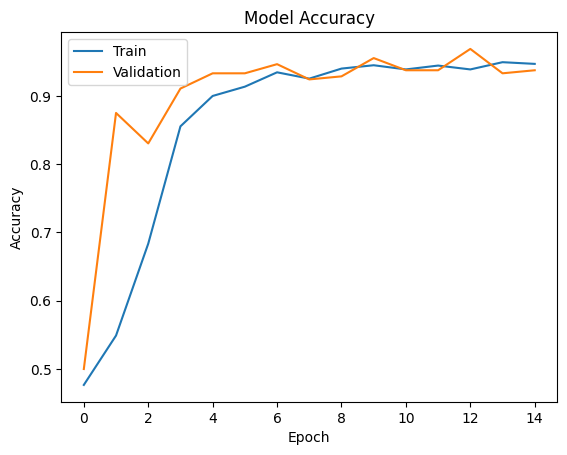

In [ ]:
plot_hist(vgg_classifier)


In [ ]:
result = model.evaluate(test_data_gen,batch_size=16)
print("test_loss, test accuracy",result)


13/13 [==============================] - 30s 3s/step - loss: 0.1312 - acc: 0.9541
test_loss, test accuracy [0.13123364746570587, 0.954081654548645]
